In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from lljs import detect_llj_vectorized as detect_lljs

plt.xkcd()  # for fancier plots

# Step 1: read the data
I downloaded a simple DOWA data file for 1 January 2008; we're interested in wind speed

In [4]:
dowa = xr.open_dataset('/home/peter9192/harriet/data/DOWA_40h12tg2_fERA5_NETHERLANDS.NL_20080101_v1.0.nc')
print(dowa.wspeed)

<xarray.DataArray 'wspeed' (time: 24, height: 17, y: 234, x: 217)>
[20717424 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 ... 2008-01-01T23:00:00
  * y        (y) float32 0.0 2500.0 5000.0 7500.0 ... 577500.0 580000.0 582500.0
  * x        (x) float32 0.0 2500.0 5000.0 7500.0 ... 535000.0 537500.0 540000.0
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
  * height   (height) float32 10.0 20.0 40.0 60.0 ... 250.0 300.0 500.0 600.0
Attributes:
    standard_name:  wind_speed
    long_name:      Wind Speed
    units:          m s-1
    grid_mapping:   Lambert_Conformal
    cell_methods:   time: point


# Step 2: Detect falloff
I think the easiest way to get LLJs is to look for the largest falloff in a wind profile. Falloff is simply the decrease in wind speed above a wind speed maximum, if there is one.

In [10]:
falloff = xr.apply_ufunc(detect_lljs, dowa.wspeed, dask='parallelized', kwargs={'output': 'falloff', 'axis': -1}, 
                         input_core_dims=[['height']], output_dtypes=[float]).rename('falloff')

print(falloff)from cartopy import crs
fig, ax = plt.subplots(subplot_kw={'projection': crs.PlateCarree()})
falloff.isel(time=12).plot(ax=ax)
plt.show()

<xarray.DataArray 'falloff' (time: 24, y: 234, x: 217)>
array([[[1.85040951, 1.80619383, 1.75820041, ..., 0.34835386,
         0.32132888, 0.29248726],
        [1.72292757, 1.6725347 , 1.61864185, ..., 0.38550353,
         0.34171975, 0.3138479 ],
        [1.59108233, 1.53472662, 1.47484827, ..., 0.41027617,
         0.35823119, 0.32944429],
        ...,
        [2.400805  , 2.38994265, 2.36998367, ..., 0.11107445,
         0.09846306, 0.08553505],
        [2.37825918, 2.36834145, 2.34980774, ..., 0.11272907,
         0.099226  , 0.08702755],
        [2.35701227, 2.34752131, 2.33029604, ..., 0.11294556,
         0.09971428, 0.0871706 ]],

       [[1.95731544, 1.98655534, 1.98897028, ..., 0.17310679,
         0.11041105, 0.12155616],
        [1.83309388, 1.85298109, 1.85015774, ..., 0.4219867 ,
         0.23825395, 0.17109632],
        [1.71548462, 1.7112987 , 1.6871357 , ..., 0.60552371,
         0.44195628, 0.27852106],
...
        [0.66140461, 0.6829071 , 0.73060513, ..., 0.        ,

## Make a figure to verify

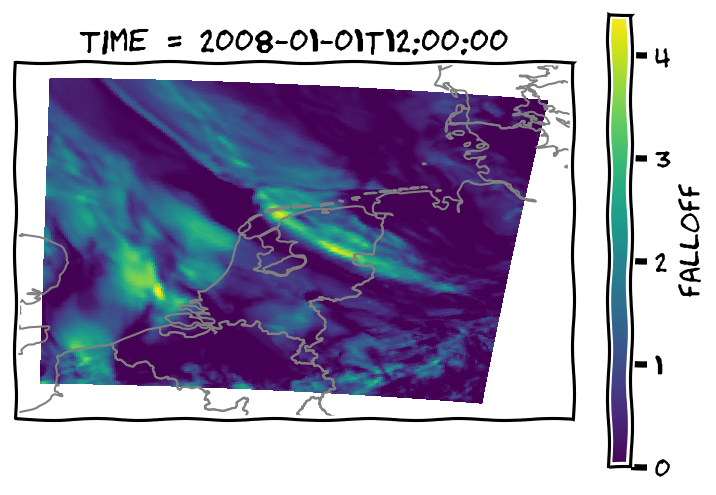

In [30]:
from cartopy import crs, feature as cf

def fancy_map():
    """Draw a nice map of the Netherlands."""
    proj = crs.PlateCarree()  # simple rectangular lat/lon grid
    borders = cf.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='grey', facecolor='none')
    moreborders = cf.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='grey', facecolor='none') # lakes_europe also exists

    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection=crs.PlateCarree())
    
    ax.add_feature(borders)
    ax.add_feature(moreborders)

    return fig, ax

fig, ax = fancy_map()
falloff.isel(time=12).plot(ax=ax, x='lon', y='lat', transform=proj)
plt.show()

# Step 3: falloff must be larger than LLJ threshold
E.g. I like to use 2 m/s

<xarray.DataArray 'falloff' (time: 24, y: 234, x: 217)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [2.400805  , 2.38994265, 2.36998367, ...,        nan,
                nan,        nan],
        [2.37825918, 2.36834145, 2.34980774, ...,        nan,
                nan,        nan],
        [2.35701227, 2.34752131, 2.33029604, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,

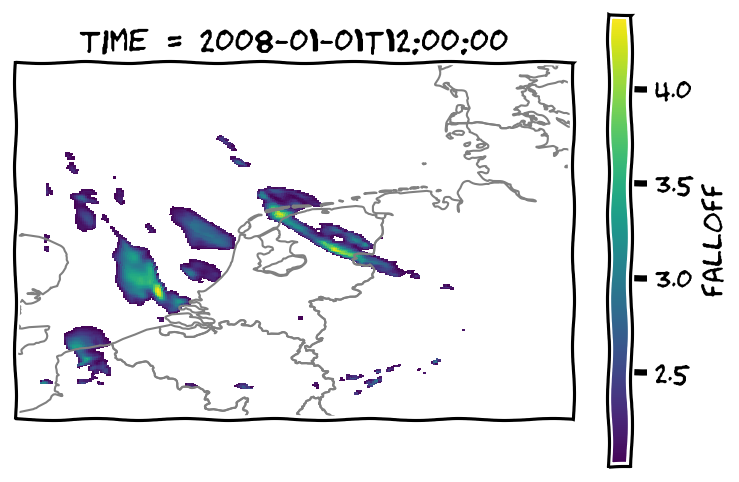

In [33]:
lljs = falloff.where(falloff>2)
print(lljs)

fig, ax = fancy_map()
lljs.isel(time=12).plot(ax=ax, x='lon', y='lat', transform=proj)
plt.show()

# Look at some individual profiles

In [43]:
import numpy as np

# Find the largest falloff value in the entire dataset (this returns the index, not the falloff value itself)
max_idx = np.argmax(falloff.values)

# The index needs to be converted back into the shape of the dataset
itime, iy, ix = np.unravel_index(max_idx, falloff.shape)
print(itime, iy, ix)

23 8 126


In [44]:
# Get the wind speed profile at this point and time
jet = dowa.wspeed.isel(time=itime, y=iy, x=ix)
print(jet)

<xarray.DataArray 'wspeed' (height: 17)>
array([ 5.366043,  6.042057,  7.581161,  8.738217,  9.671964, 10.357558,
       10.808641, 11.060699, 11.105141, 11.149754, 11.102615, 10.968835,
       10.679317, 10.208861,  9.319245,  4.782704,  3.060687], dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-01-01T23:00:00
    y        float32 20000.0
    x        float32 315000.0
    lon      float32 ...
    lat      float32 ...
  * height   (height) float32 10.0 20.0 40.0 60.0 ... 250.0 300.0 500.0 600.0
Attributes:
    standard_name:  wind_speed
    long_name:      Wind Speed
    units:          m s-1
    grid_mapping:   Lambert_Conformal
    cell_methods:   time: point


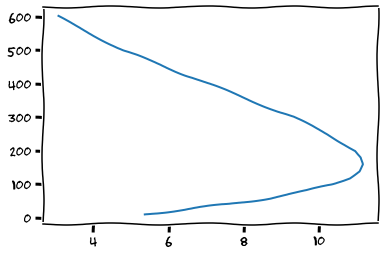

In [45]:
fig, ax = plt.subplots()
ax.plot(jet.values, jet.height)